
<a id='mccall-with-sep'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search II: Search and Separation


<a id='index-0'></a>

## Contents

- [Job Search II: Search and Separation](#Job-Search-II:-Search-and-Separation)  
  - [Overview](#Overview)  
  - [The Model](#The-Model)  
  - [Solving the Model using Dynamic Programming](#Solving-the-Model-using-Dynamic-Programming)  
  - [Implementation](#Implementation)  
  - [The Reservation Wage](#The-Reservation-Wage)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Previously [we looked](mccall_model.html) at the McCall job search model [[McC70]](zreferences.html#mccall1970) as a way of understanding unemployment and worker decisions

One unrealistic feature of the model is that every job is permanent

In this lecture we extend the McCall model by introducing job separation

Once separation enters the picture, the agent comes to view

- the loss of a job as a capital loss, and  
- a spell of unemployment as an *investment* in searching for an acceptable job  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.1.0")

In [2]:
using LinearAlgebra, Statistics, Compat
using Distributions, Expectations, Parameters, NLsolve, Plots

## The Model

The model concerns the life of an infinitely lived worker and

- the opportunities he or she (let’s say he to save one character) has to work at different wages  
- exogenous events that destroy his current job  
- his decision making process while unemployed  


The worker can be in one of two states: employed or unemployed

He wants to maximize


<a id='equation-objective'></a>
$$
{\mathbb E} \sum_{t=0}^\infty \beta^t u(Y_t) \tag{1}
$$

The only difference from the [baseline model](mccall_model.html) is that
we’ve added some flexibility over preferences by introducing a utility function $ u $

It satisfies $ u'> 0 $ and $ u'' < 0 $

### Timing and Decisions

Here’s what happens at the start of a given period in our model with search and separation

If currently *employed*, the worker consumes his wage $ w $, receiving utility $ u(w) $

If currently *unemployed*, he

- receives and consumes unemployment compensation $ c $  
- receives an offer to start work *next period* at a wage $ w' $ drawn from a known distribution $ p_1, \ldots, p_n $  


He can either accept or reject the offer

If he accepts the offer, he enters next period employed with wage $ w' $

If he rejects the offer, he enters next period unemployed

When employed, the agent faces a constant probability $ \alpha $ of becoming unemployed at the end of the period

(Note: we do not allow for job search while employed—this topic is taken
up in a [later lecture](jv.html))

## Solving the Model using Dynamic Programming

Let

- $ V(w) $ be the total lifetime value accruing to a worker who enters the current period *employed* with wage $ w $  
- $ U $ be the total lifetime value accruing to a worker who is *unemployed* this period  


Here *value* means the value of the objective function [(1)](#equation-objective) when the worker makes optimal decisions at all future points in time

Suppose for now that the worker can calculate the function $ V $ and the constant $ U $ and use them in his decision making

Then $ V $ and $ U $  should satisfy


<a id='equation-bell1-mccall'></a>
$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ] \tag{2}
$$

and


<a id='equation-bell2-mccall'></a>
$$
U = u(c) + \beta \sum_i \max \left\{ U, V(w_i) \right\} p_i \tag{3}
$$

Let’s interpret these two equations in light of the fact that today’s tomorrow is tomorrow’s today

- The left hand sides of equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) are the values of a worker in a particular situation *today*  
- The right hand sides of the equations are the discounted (by $ \beta $) expected values of the possible situations that worker can be in *tomorrow*  
- But *tomorrow* the worker can be in only one of the situations whose values *today* are on the left sides of our two equations  


Equation [(3)](#equation-bell2-mccall) incorporates the fact that a currently unemployed worker will maximize his own welfare

In particular, if his next period wage offer is $ w' $, he will choose to remain unemployed unless  $ U < V(w') $

Equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) are the Bellman equations
for this model

Equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) provide enough information to solve out for both $ V $ and $ U $

Before discussing this, however, let’s make a small extension to the model

### Stochastic Offers

Let’s suppose now that unemployed workers don’t always receive job offers

Instead, let’s suppose that unemployed workers only receive an offer with probability $ \gamma $

If our worker does receive an offer, the wage offer is drawn from $ p $ as before

He either accepts or rejects the offer

Otherwise the model is the same

With some thought, you  will be able to convince yourself that $ V $ and $ U $  should now satisfy


<a id='equation-bell01-mccall'></a>
$$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ] \tag{4}
$$

and


<a id='equation-bell02-mccall'></a>
$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i \tag{5}
$$

### Solving the Bellman Equations

We’ll use the same iterative approach to solving the Bellman equations that we
adopted in the [first job search lecture](mccall_model.html)

Here this amounts to

1. make guesses for $ U $ and $ V $  
1. plug these guesses into the right hand sides of [(4)](#equation-bell01-mccall) and [(5)](#equation-bell02-mccall)  
1. update the left hand sides from this rule and then repeat  


In other words, we are iterating using the rules


<a id='equation-bell1001'></a>
$$
V_{n+1} (w_i) = u(w_i) + \beta [(1-\alpha)V_n (w_i) + \alpha U_n ] \tag{6}
$$

and


<a id='equation-bell2001'></a>
$$
U_{n+1} = u(c) +
    \beta (1 - \gamma) U_n +
    \beta \gamma \sum_i \max \{ U_n, V_n(w_i) \} p_i \tag{7}
$$

starting from some initial conditions $ U_0, V_0 $

Formally, we can define a “Bellman operator” T which maps:


<a id='equation-bellman-operator'></a>
$$
TV(\cdot) = u(\cdot) + \beta  (1-\alpha)V(\cdot) + \alpha U \tag{8}
$$

In which case we are searching for a fixed point


<a id='equation-bellman-operator-fp'></a>
$$
TV^{*} = V^* \tag{9}
$$

As before, the system always converges to the true solutions—in this case,
the $ V $ and $ U $ that solve [(4)](#equation-bell01-mccall) and [(5)](#equation-bell02-mccall)

A proof can be obtained via the Banach contraction mapping theorem

## Implementation

Let’s implement this iterative process

In [3]:
using Distributions, LinearAlgebra, Compat, Expectations, Parameters, NLsolve, Plots

function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    # α, β, σ, c, γ, w = mcm.α, mcm.β, mcm.σ, mcm.c, mcm.γ, mcm.w
    @unpack α, β, σ, c, γ, w, dist, u = mcm

    # parameter validation
    @assert c > 0.0
    @assert minimum(w) > 0.0 # perhaps not strictly necessary, but useful here

    # necessary objects
    u_w = u.(w, σ)
    u_c = u(c, σ)
    E = expectation(dist) # expectation operator for wage distribution

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        [u_w + β * ((1 - α) * V .+ α * U); u_c + β * (1 - γ) * U + β * γ * E * max.(U, V)]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w̄ = Inf
    else
        w̄ = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (V = V, U = U, w̄ = w̄)
end

solve_mccall_model (generic function with 1 method)

The approach is to iterate until successive iterates are closer together than some small tolerance level

We then return the current iterate as an approximate solution

Let’s plot the approximate solutions $ U $ and $ V $ to see what they look like

We’ll use the default parameterizations found in the code above

In [4]:
# a default utility function
u(c, σ) = (c^(1 - σ) - 1) / (1 - σ)

# model constructor
McCallModel = @with_kw (α = 0.2,
    β = 0.98, # discount rate
    γ = 0.7,
    c = 6.0, # unemployment compensation
    σ = 2.0,
    u = u, # utility function
    w = range(10, 20, length = 60), # wage values
    dist = BetaBinomial(59, 600, 400)) # distribution over wage values

#5 (generic function with 2 methods)

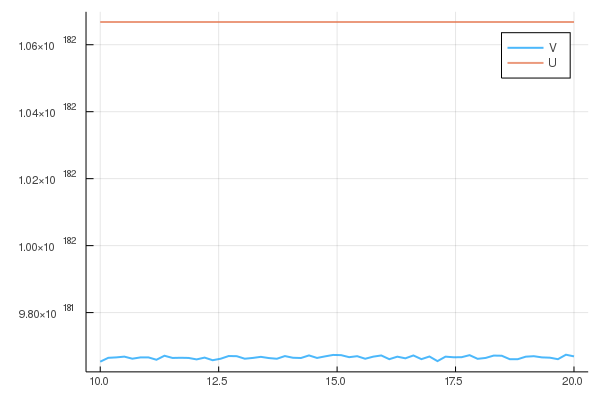

In [5]:
# plots setting
gr(fmt=:png);

mcm = McCallModel()
@unpack V, U = solve_mccall_model(mcm)
U_vec = fill(U, length(mcm.w))

plot(mcm.w, [V U_vec], lw = 2, α = 0.7, label = ["V" "U"])

The value $ V $ is increasing because higher $ w $ generates a higher wage flow conditional on staying employed

At this point, it’s natural to ask how the model would respond if we perturbed the parameters

These calculations, called comparative statics, are performed in the next section

## The Reservation Wage

Once $ V $ and $ U $ are known, the agent can use them to make decisions in the face of a given wage offer

If $ V(w) > U $, then working at wage $ w $ is preferred to unemployment

If $ V(w) < U $, then remaining unemployed will generate greater lifetime value

Suppose in particular that $ V $ crosses $ U $ (as it does in the preceding figure)

Then, since $ V $ is increasing, there is a unique smallest $ w $ in the set of possible wages such that $ V(w) \geq U $

We denote this wage $ \bar w $ and call it the reservation wage

Optimal behavior for the worker is characterized by $ \bar w $

- if the  wage offer $ w $ in hand is greater than or equal to $ \bar w $, then the worker accepts  
- if the  wage offer $ w $ in hand is less than $ \bar w $, then the worker rejects  


If $ V(w) < U $ for all $ w $, then the function returns np.inf

Let’s use it to look at how the reservation wage varies with parameters

In each instance below we’ll show you a figure and then ask you to reproduce it in the exercises

### The Reservation Wage and Unemployment Compensation

First, let’s look at how $ \bar w $ varies with unemployment compensation

In the figure below, we use the default parameters in the McCallModel tuple, apart from
c (which takes the values given on the horizontal axis)

<img src="_static/figures/mccall_resw_c.png" style="width:100%;height:100%">

  
As expected, higher unemployment compensation causes the worker to hold out for higher wages

In effect, the cost of continuing job search is reduced

### The Reservation Wage and Discounting

Next let’s investigate how $ \bar w $ varies with the discount rate

The next figure plots the reservation wage associated with different values of
$ \beta $

<img src="_static/figures/mccall_resw_beta.png" style="width:100%;height:100%">

  
Again, the results are intuitive: More patient workers will hold out for higher wages

### The Reservation Wage and Job Destruction

Finally, let’s look at how $ \bar w $ varies with the job separation rate $ \alpha $

Higher $ \alpha $ translates to a greater chance that a worker will face termination in each period once employed

<img src="_static/figures/mccall_resw_alpha.png" style="width:100%;height:100%">

  
Once more, the results are in line with our intuition

If the separation rate is high, then the benefit of holding out for a higher wage falls

Hence the reservation wage is lower

## Exercises

### Exercise 1

Reproduce all the reservation wage figures shown above

### Exercise 2

Plot the reservation wage against the job offer rate $ \gamma $

Use

In [6]:
γ_vals = range(0.05,  0.95, length = 25)

0.05:0.0375:0.95

Interpret your results

## Solutions

### Exercise 1

Using the solve_mccall_model function mentioned earlier in the lecture,
we can create an array for reservation wages for different values of $ c $,
$ \beta $ and $ \alpha $ and plot the results like so

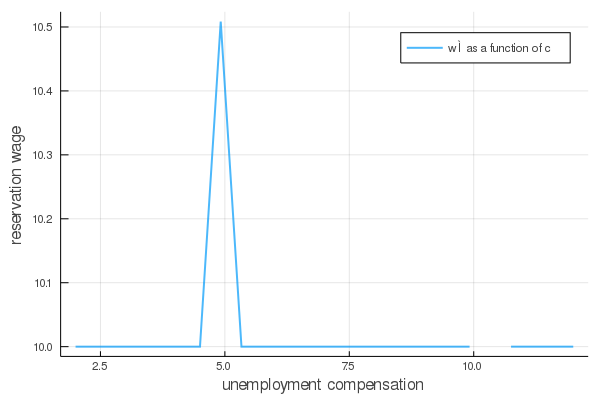

In [7]:
c_vals = range(2,  12, length = 25)

models = [McCallModel(c = cval) for cval in c_vals]
sols = solve_mccall_model.(models)
w̄_vals = [sol.w̄ for sol in sols]

plot(c_vals,
    w̄_vals,
    lw = 2,
    α = 0.7,
    xlabel = "unemployment compensation",
    ylabel = "reservation wage",
    label = "w̄ as a function of c")

Note that we could’ve done the above in one pass (which would be important if, for example, the parameter space was quite large)

In [8]:
w̄_vals = [solve_mccall_model(McCallModel(c = cval)).w̄ for cval in c_vals];
# doesn't allocate new arrays for models and solutions

### Exercise 2

Similar to above, we can plot $ \bar w $ against $ \gamma $ as follows

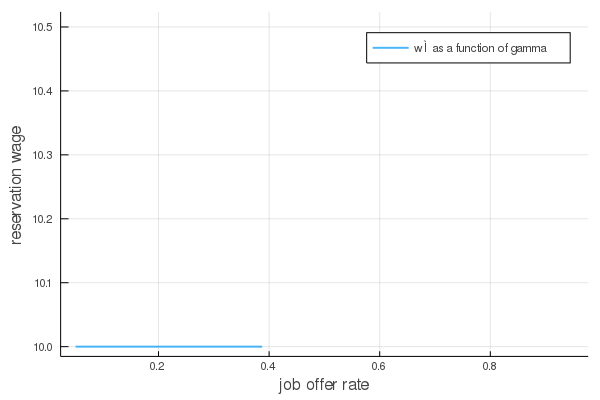

In [9]:
γ_vals = range(0.05,  0.95, length = 25)

models = [McCallModel(γ = γval) for γval in γ_vals]
sols = solve_mccall_model.(models)
w̄_vals = [sol.w̄ for sol in sols]

plot(γ_vals, w̄_vals, lw = 2, α = 0.7, xlabel = "job offer rate",
     ylabel = "reservation wage", label = "w̄ as a function of gamma")

As expected, the reservation wage increases in $ \gamma $

This is because higher $ \gamma $ translates to a more favorable job
search environment

Hence workers are less willing to accept lower offers